# AIT Deep Learning Pedestrian Detection Project
Note: We used GitHub Copilot to generate some of the code, such as displaying images using matplotlib.

References: 
- https://keras.io/examples/vision/yolov8/
- https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/
- https://keras.io/guides/keras_cv/object_detection_keras_cv/

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import json
import random

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras_cv import bounding_box, visualization
from keras_cv.losses import CIoULoss
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard

2024-05-15 22:51:53.021486: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 22:51:53.046938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 22:51:53.046974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 22:51:53.046979: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 22:51:53.051299: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


/home/lehoangchibach/anaconda3/envs/gpu11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We are running this program on Bach's computer that has GPU.

In [3]:
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],
)
logical_gpus = tf.config.list_logical_devices("GPU")
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


2024-05-15 22:51:54.766238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 22:51:54.782974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 22:51:54.783241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
BATCH_SIZE = 10
GLOBAL_CLIPNORM = 10.0

class_mapping = {
    0: "pedestrian"
}  # We only have one class for our bounding box, pedestrian.

In [5]:
""" Returns bounding boxes for every image
"""


def convert_annotations(img_type: str) -> (int, dict):
    with open(
        f"annotations/dhd_pedestrian_traffic_{img_type}.json"
    ) as f:
        annotations = json.load(f)

    boxes = {}
    image_ids = set()
    for anno in annotations["annotations"]:
        image_id = anno["image_id"]

        if image_id not in image_ids:
            image_ids.add(image_id)

        if image_id not in boxes:
            boxes[image_id] = {}
            boxes[image_id][
                "image_path"
            ] = f"images/{img_type}/{image_id}.jpg"
            boxes[image_id]["boxes"] = []
            boxes[image_id]["class_ids"] = []
        boxes[image_id]["boxes"].append(anno["bbox"])
        boxes[image_id]["class_ids"].append(0)

    return image_ids, boxes


""" Load image into uint8 tensor
"""


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


""" Load image and bounding_boxes pair
"""


def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


## No augumentation for the test dataset
def process_test():
    image_ids, annos = convert_annotations("val")

    image_paths = []
    boxes = []
    class_ids = []
    for i in image_ids:
        x = annos[i]
        image_paths.append(x["image_path"])
        boxes.append(x["boxes"])
        class_ids.append(x["class_ids"])

    bbox = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(class_ids)
    image_paths = tf.ragged.constant(image_paths)

    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

    ds = data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(BATCH_SIZE * 4)
    ds = ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.map(
        keras_cv.layers.Resizing(
            640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


def count_boxes(bbox):
    box_batch = bbox["boxes"]
    res = []
    for batch in box_batch:
        boxes_cnt = 0
        for box in batch:
            if box[0] != -1:
                boxes_cnt += 1
        res.append(boxes_cnt)
    return res


def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

## Load model

We load the fully trained model and re-compile it.

In [6]:
yolo = keras.models.load_model("./models/fully_trained_yolov8xs.keras")
optimizer = tf.keras.optimizers.SGD(global_clipnorm=GLOBAL_CLIPNORM)
# yolo.load_weights('./weights/best_weights.hdf5')
yolo.compile(
    optimizer=optimizer,
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

2024-05-15 22:51:55.066554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 7.81GiB (8388608000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


/home/lehoangchibach/anaconda3/envs/gpu11/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/lehoangchibach/anaconda3/envs/gpu11/lib/python3.11/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [7]:
yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.53,
    confidence_threshold=0.5,
)

test_ds = process_test()
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

result = yolo.evaluate(test_ds, return_dict=True)
print(result)

2024-05-15 22:52:05.481759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-15 22:52:05.482041: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 22:52:05.484820: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 22:52:05.484871: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-15 22:52:05.488507: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 22:52:05.488566: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-15 22:52:05.736253: I te

  3/213 [..............................] - ETA: 17s - loss: 3.2922 - box_loss: 2.0008 - class_loss: 1.2914

2024-05-15 22:52:08.619842: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 22:52:08.619879: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-15 22:52:08.620144: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 22:52:08.620165: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


213/213 [==============================] - 39s 147ms/step - loss: 3.3544 - box_loss: 2.0667 - class_loss: 1.2877
{'loss': 3.3544044494628906, 'box_loss': 2.0667080879211426, 'class_loss': 1.2876944541931152}


### 2-4 Prediction

1/1 [==============================] - 2s 2s/step


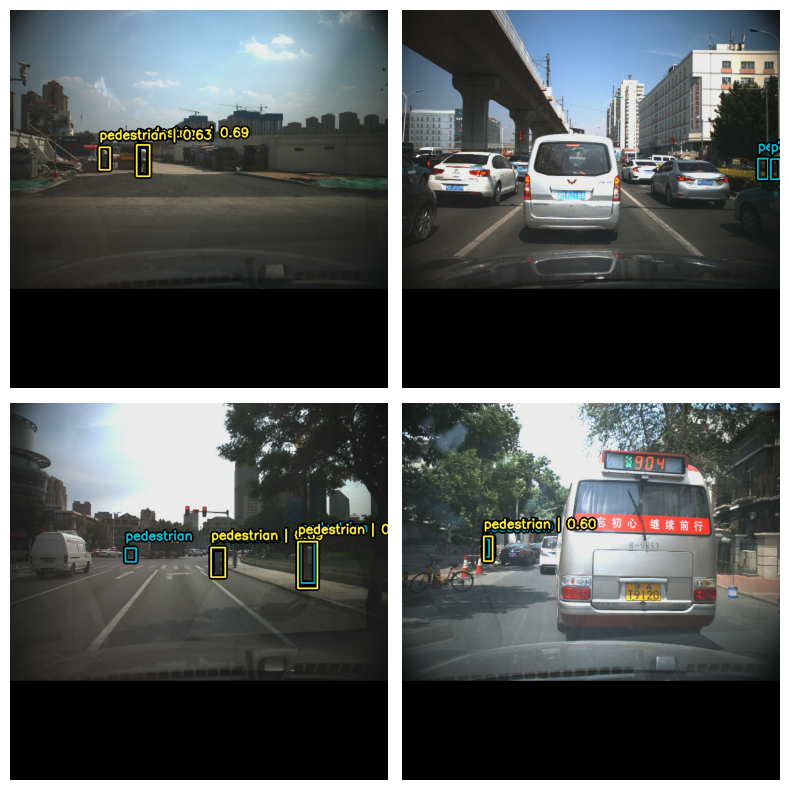

In [19]:
yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.53,
    confidence_threshold=0.53,
)
image, bbox = next(iter(test_ds))
y_pred = yolo.predict(image)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    y_true=bbox,
    y_pred=y_pred,
    scale=4,
    rows=2,
    cols=2,
    show=True,
    font_scale=0.7,
    class_mapping=class_mapping,
    bounding_box_format='xywh'
)

In [17]:
cnt = 0
ped_cnt = []
pred_ped_cnt = []
for image, bbox in test_ds:
    ped_cnt += count_boxes(bbox)

    y_pred = yolo.predict(image, verbose=0)
    y_pred = bounding_box.to_ragged(y_pred)
    pred_ped_cnt += count_boxes(y_pred)

true_pred = 0
for truth, pred in zip(ped_cnt, pred_ped_cnt):
    if truth == pred:
        true_pred += 1
print(f"Accuracy: {true_pred}/{len(ped_cnt)}: {true_pred / len(ped_cnt) * 100}%")
print(f"MSE: {mean_squared_error(ped_cnt, pred_ped_cnt)}")

Accuracy: 351/2130: 16.47887323943662%
MSE: 7.092018779342723


In [ ]:
gc.collect()
K.clear_session()